In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import TensorDataset, DataLoader

In [58]:
# Zebras aus dem Kaggle horse2zebra Dataset: https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset?resource=download
def plot_results(imgs, labels=None):
    if labels is None:
        labels = [None for i in range(len(imgs))]
    plt.figure(figsize=(10, 10))
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis("off")

def normalise(img):
    img = np.float32(img)
    img -= np.min(img)
    img /= np.max(img)
    img = img*2 - 1
    return img

def norm_and_resize_with_padding(img, size):
    size_max = np.max(img.shape)
    r = size/size_max
    img = cv2.resize(img, (int(round(img.shape[1]*r)), int(round(img.shape[0]*r))))
    img = normalise(img)
    offset_height = (size - img.shape[0])//2
    offset_width = (size - img.shape[1])//2
    canvas = np.float32(-np.ones((size,size,3)))
    canvas[offset_height : offset_height + img.shape[0], offset_width : offset_width + img.shape[1]] = img
    return canvas

def import_images_from_folder(folder_path, size):
    imgs = []
    for relative_img_path in os.listdir(folder_path):
        img = cv2.imread(folder_path + relative_img_path)
        imgs.append(norm_and_resize_with_padding(img, size))
    print('Imported '+str(len(imgs))+' images.')
    return imgs

def to_uint8(img):
    return np.uint8((img + 1) * 127.5)

Imported 1473 images.


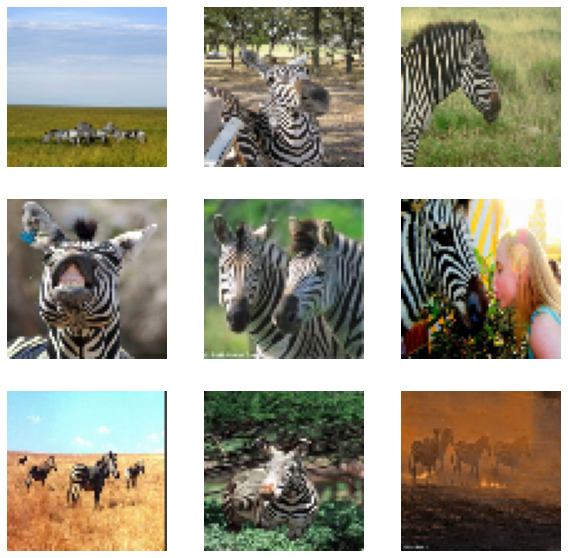

In [60]:
img_size = 64
images = import_images_from_folder('./zebras/', img_size)
plot_results([to_uint8(x) for x in images[:9]])

In [13]:
class SynthesisLayer(torch.nn.Module):
    def __init__(self,
        in_channels,                    # Number of input channels.
        out_channels,                   # Number of output channels.
        upsample,                       # Bool definining whether to upsample featuremaps
        non_linearity,                  # Bool definining if non-linearity is applied.
        normalization                   # Bool definining whether to apply instance-norm before conv
    ):
        super().__init__()

        # Write args
        self.upsample        = upsample
        self.normalization   = normalization
        self.non_linearity   = non_linearity
        
        # Define Convolution
        self.convolution = torch.nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3, 
            stride=1,
            padding=(1,1))

        # Define additional layers
        if normalization:
            self.instance_norm = torch.nn.InstanceNorm2d(in_channels)
   
        if non_linearity:
            self.leaky_relu = torch.nn.LeakyReLU()

    def forward(self, x):
        if self.upsample:
            x = torch.nn.functional.interpolate(x, scale_factor=2, mode='bilinear')
        if self.normalization:
            x = self.instance_norm(x)
        x = self.convolution(x)
        if self.non_linearity:
            x = self.leaky_relu(x)
        return x

class Generator(torch.nn.Module):
    # ------------------------------------------------- #
    # Konstruktor
    def __init__(
        self,
        img_size,
        n_latent_dimensions,
        channel_multiplier,

        ):
        super().__init__()

        # FC-Layer konstruieren
        self.fc = torch.nn.Linear(
            in_features=n_latent_dimensions,
            out_features=4*4*64*channel_multiplier
        )

        # 4x4 Convolution ohne Upsampling konstruieren
        self.synthesis_layers = []
        self.synthesis_layers.append(
            SynthesisLayer(
                in_channels=64*channel_multiplier,
                out_channels=64*channel_multiplier,
                upsample=False,
                non_linearity=True,
                normalization=True
            )
        )

        # Convolutions mit Upsampling konstruieren
        for i in range(int(np.log2(img_size)-2)):
            self.synthesis_layers.append(
                SynthesisLayer(
                    in_channels=64*channel_multiplier,
                    out_channels=64*channel_multiplier,
                    upsample=True,
                    non_linearity=True,
                    normalization=True
                )
            )

        # RGB-Output Convolution konstruieren
        self.synthesis_layers.append(
            SynthesisLayer(
                in_channels=64*channel_multiplier,
                out_channels=3,
                upsample=False,
                non_linearity=False,
                normalization=False
            )
        )

    # ------------------------------------------------- #
    # forward-Methode
    def forward(self, latent_code):
        x = self.fc(latent_code)
        x = torch.reshape(x, (x.shape[0],64,4,4))
        for synthesis_layer in self.synthesis_layers:
            x = synthesis_layer(x)
        return x

In [14]:
n_latent_dimensions = 100

G = Generator(
    img_size = img_size,
    n_latent_dimensions = n_latent_dimensions,
    channel_multiplier = 1
)
z = torch.randn(16, n_latent_dimensions)
x = G.forward(z)
print(x.shape)

torch.Size([16, 3, 64, 64])


In [15]:
class DiscriminatorLayer(torch.nn.Module):
    def __init__(self,
        in_channels,                    # Number of input channels.
        out_channels,                   # Number of output channels.
        downsample,                     # Bool definining whether to downsample featuremaps
        non_linearity,                  # Bool definining if non-linearity is applied.
        normalization
    ):
        super().__init__()

        # Write args
        self.downsample      = downsample
        self.normalization   = normalization
        self.non_linearity   = non_linearity

        # Define Convolution
        self.convolution = torch.nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=3, 
            stride=1,
            padding=(1,1))

        # Define additional layers
        if downsample:
            self.pool = torch.nn.AvgPool2d(2, stride=None)
        if normalization:
            self.instance_norm = torch.nn.InstanceNorm2d(in_channels)
        if non_linearity:
            self.leaky_relu = torch.nn.LeakyReLU()

    def forward(self, x):
        if self.normalization:
            x = self.instance_norm(x)
        x = self.convolution(x)
        if self.non_linearity:
            x = self.leaky_relu(x)
        if self.downsample:
            x = self.pool(x)
        return x

class Discriminator(torch.nn.Module):
    # ------------------------------------------------- #
    # Konstruktor
    def __init__(
        self,
        img_size,
        channel_multiplier
        ):
        super().__init__()

        # Convolutions mit Downsampling konstruieren
        self.discriminator_layers = []
        in_channels = 3
        for i in range(int(np.log2(img_size)-2)):
            self.discriminator_layers.append(
                DiscriminatorLayer(
                    in_channels=in_channels,
                    out_channels=64*channel_multiplier,
                    downsample=True,
                    non_linearity=True,
                    normalization=False
                )
            )
            in_channels = 64*channel_multiplier

        # 4x4 Convolution ohne Downsampling
        self.discriminator_layers.append(
            DiscriminatorLayer(
                in_channels=64*channel_multiplier,
                out_channels=64*channel_multiplier,
                downsample=False,
                non_linearity=True,
                normalization=False
            )
        )

        # FC-Layer konstruieren
        self.fc = torch.nn.Linear(
            in_features=4*4*64*channel_multiplier,
            out_features=1
        )

    # ------------------------------------------------- #
    # forward-Methode
    def forward(self, img):
        x = img
        for discriminator_layer in self.discriminator_layers:
            x = discriminator_layer(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [16]:
# Model definieren
D = Discriminator(
    img_size=img_size,
    channel_multiplier=1
    )

In [17]:
# Kurzer Test, ob alles wie gewünscht funktioniert. 
z = torch.randn(16, 3, 64, 64)
x = D.forward(z)
print(x.shape)

torch.Size([16, 1])


In [20]:
# Schnappen wir uns unsere GPU bzw. CPU wenn keine GPU vorhanden ist.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Nun kopieren wir unsere Models auf das device mit der Methode .to
D = D.to(device)
G = G.to(device)

# Den Optimizern in PyTorch übergeben wir die Methode 'parameters' des zu optimierenden Models und die learning rate.
opt_discriminator = torch.optim.Adam(D.parameters(), lr=1e-4)
opt_generator = torch.optim.Adam(G.parameters(), lr=1e-4)

# Binary crossentropy
def binary_crossentropy(pred, true):
    loss = -(true * torch.log(pred+1e-7) + (1-true) * torch.log(1-pred+1e-7))
    loss = torch.mean(loss)
    return loss

In [36]:
def get_loader(images, n_latent_dimensions):
    latent_codes = np.float32(np.random.normal(0, 1, (len(images), n_latent_dimensions)))
    images = np.float32(images)
    images = np.transpose(images, (0, 3, 1, 2))
    latent_codes = torch.Tensor(latent_codes) # transform to torch tensor
    images = torch.Tensor(images)
    dataset = TensorDataset(latent_codes, images) # create your datset
    train_loader = DataLoader(
        dataset,
        batch_size=128,
        shuffle=True,
        num_workers=4)
    return train_loader

In [ ]:
def plot_results(imgs, index):
    plt.figure(figsize=(10, 10))
    imgs = [x.detach().numpy() for x in imgs]
    imgs = [np.uint8(np.clip((img+1)*127.5, 0, 255)) for img in imgs]
    imgs = [np.transpose(x, (1,2,0)) for x in imgs]
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.axis("off")
    plt.savefig('output/'+str(index)+'.jpg')

In [67]:
'''
Trainingsloop
'''
from tqdm import tqdm

def train(n_epochs):
    # init latent codes for testing
    z = np.float32(np.random.normal(0, 1, (9, n_latent_dimensions)))
    z = torch.tensor(z)
    z.to(device)

    for epoch in range(n_epochs):
        # Tests rendern
        generated = G(z)
        plot_results(generated, epoch)

        # loader
        train_loader = get_loader(images, n_latent_dimensions)
        d_loss_epoch = 0
        g_loss_epoch = 0
        for batch_latent_codes, batch_images in tqdm(train_loader):
            # Batch auf das device laden
            batch_latent_codes = batch_latent_codes.to(device)
            batch_images = batch_images.to(device)
            # Gradienten resetten.
            opt_discriminator.zero_grad()
            opt_generator.zero_grad()
            # Fakes generieren
            batch_fakes = G(batch_latent_codes)
            # Discriminator predictions
            d_fake = D(batch_fakes)
            d_real = D(batch_images)
            # discriminator losses berechnen
            d_loss_fake = binary_crossentropy(d_fake, 0)
            d_loss_real = binary_crossentropy(d_real, 1)
            d_loss = d_loss_fake + d_loss_real
            # generator loss berechnen
            g_loss = binary_crossentropy(d_fake, 1)
            # Gradienten berechnen
            total_loss = d_loss + g_loss
            total_loss.backward()
            # Gewichte anhand der Gradienten updaten
            opt_discriminator.step()
            opt_generator.step()
            # Loss zum gesamten Loss der Epoche hinzufügen
            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
        
        # Durchschnittlichen Loss der Epoche berechnen
        d_loss_epoch = d_loss_epoch / len(train_loader)
        g_loss_epoch = g_loss_epoch / len(train_loader)
        
        # Loss der Epochen anzeigen
        print("epoch : {}/{}, d_loss = {}, g_loss = {:.6f}".format(epoch + 1, n_epochs, d_loss_epoch, g_loss_epoch))

train(n_epochs=1000)

100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


epoch : 1/1000, d_loss = 1.8710749049981434, g_loss = 1.651959


100%|██████████| 12/12 [00:28<00:00,  2.34s/it]


epoch : 2/1000, d_loss = 1.8499675591786702, g_loss = 1.624153


 42%|████▏     | 5/12 [00:12<00:17,  2.47s/it]